## Praktische Aufgaben – Blatt 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

### Vorausgesetzte Pakete

Installiert euch bitte die folgenden Pakete in eure python Umgebung:
- https://hmmlearn.readthedocs.io/en/latest/index.html
- https://pandas.pydata.org/pandas-docs/stable/index.html
- https://seaborn.pydata.org/

Dies könnt ihr mit diesem Befehl tun: 
```
pip install hmmlearn pandas seaborn
```

In [2]:
import hmmlearn.hmm as hmm
import pandas as pd
import seaborn as sns

### Vorbereitung

Im Folgenden möchten wir Bewegungsdaten automatisch erkennen und segmentieren.
Es gibt drei verschiedene Bewegungen.
Die Daten sind mit verschiedenen Sensoren (EMG, Akzelerometer, Gyroskop und Goniometer) aufgenommen worden. Diese sind um das Knie herum angebracht und tasten mit 1000 Hz ab. Anbei eine Grafik der Sensorpositionen:

<img src="SensorPlacement.png" style="width: 30%">

In [3]:
channels = np.array([
        'EMG1', 'EMG2', 'EMG3', 'EMG4',
        'Airborne',
        'Piezo',
        'AccUp1', 'AccUp2', 'AccUp3',
        'Gonio1',
        'AccLow1', 'AccLow2', 'AccLow3',
        'Gonio2',
        'GyroUp1', 'GyroUp2', 'GyroUp3',
        'Force',
        'GyroLow1', 'GyroLow2', 'GyroLow3'
    ])

# Laden der Test und Trainingsdaten
data, labels = np.load('data.npy')[:, :-1], pd.read_csv('data.csv')[:-1]
labels['Duration'] = labels['End'] - labels['Start']

labels.head()

,Activity,Start,End,Duration
0,nothing,0,5899,5899
1,cspin-l,5900,7009,1109
2,nothing,7010,9389,2379
3,walk,9390,11139,1749
4,nothing,11140,12439,1299


### Aufgabe 1: Visualisierung 

**1.** Plottet die durchschnittliche Dauer der verschiedenen Aktivitäten/Bewegungen mit ihren jeweiligen Standardabweichungen. Auf eurer x-Achse sollen also die drei Aktivitäten und auf der y-Achse die Durchschnittsdauern mit den Standardabweichungen als Fehlerbalken abgebildet werden.

Macht euch hierfür mit `seaborn` (aka `sns`) vertraut und nutzt dessen Funktion `sns.barplot` (https://seaborn.pydata.org/generated/seaborn.barplot.html?highlight=barplot#seaborn.barplot). Achtet hierbei darauf, die Funktion idiomatisch zu nutzen, also so wie von `seaborn` vorgesehen. Schaut euch dazu gern ein paar Beispiele an.

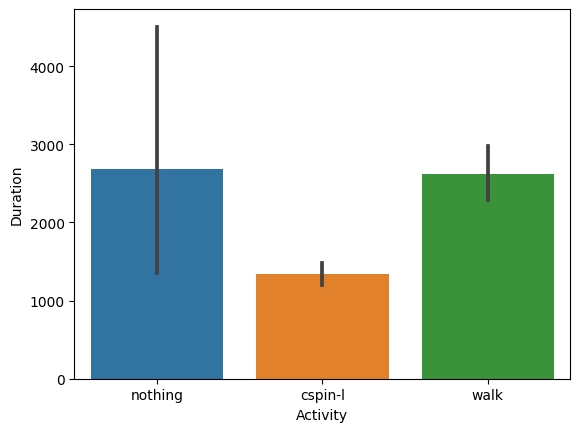

In [8]:
# YOUR CODE HERE
a = sns.barplot(x='Activity', y='Duration', data=labels)

**2.** Plottet jeweils exemplarisch den Goniometer (Winkelmesser) Kanal `Gonio2` für die jeweils erste Instanz der drei Bewegungen. Ihr könnt hierfür entweder `seaborn` oder `plt.plot()` nutzen. 

_Hinweis_: Wenn ihr möchtet, könnt ihr für diese Aufgabe eine sehr einfache Lösung mit `numpy` slicing (`arr[start:end]`) nutzen, um die wesentlichen Datensegmente zu bekommen. 

<Axes: >

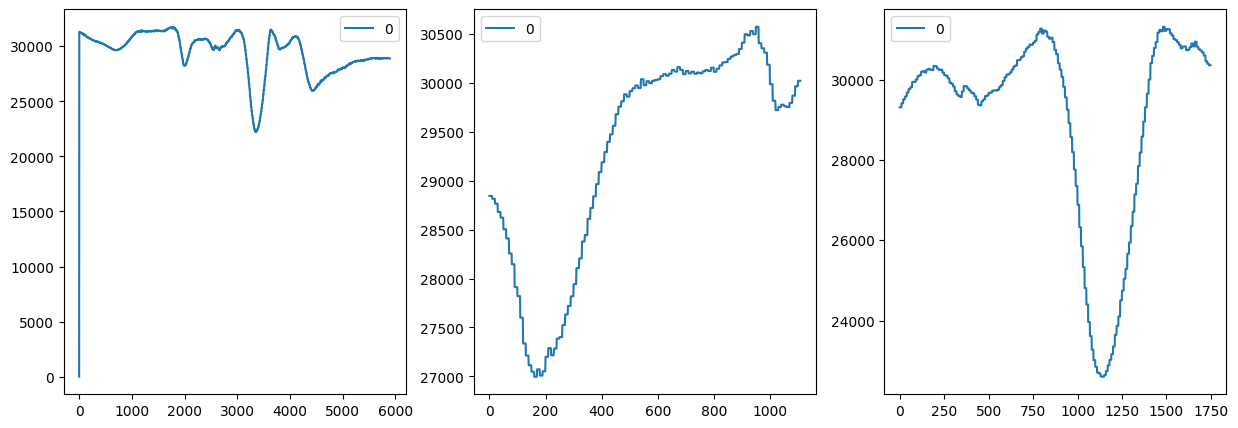

In [15]:
gonio_data = data[:, channels == 'Gonio2']

# YOUR CODE HERE
figures, axes = plt.subplots(1, 3, figsize=(15,5))
sns.lineplot(ax=axes[0], data=gonio_data[0:5900])
sns.lineplot(ax=axes[1], data=gonio_data[5900:7009])
sns.lineplot(ax=axes[2], data=gonio_data[9390:11139])

**3.** Basierend auf den Plots aus 1 und 2:
1. Sind diese drei Klassen gut trennbar?
2. Würdet ihr hier einen Token- oder Sequenzklassikator wählen? Warum?
   

1.\
Obwohl 'cspin' kürzer ist als die anderen Aktivitäten und bei 'walk' im Gonio-Signal ein signifikanter Ausschlag zu sehen ist, würden wir sagen, dass das nicht reicht, um die klassen gut zu trennen.

2.\
In diesem Fall würden wir einen Tokenklassifikator wählen, da die Übergangswahrscheinlichkeiten nicht von Bedeutung sind. Das ist der Fall, weil der Übergang der Aktivitäten immer von oder zu 'nothing' ist.

Die folgende Graphik zeigt den typischen Verlauf eines Ganges anhand der drei Winkel am Knöchel, Knie und an der Hüfte.

<img src="gait_cycle.png" style="width: 50%">

Graphik aus Kapitel 2, Seite 59 aus:   
Whittle, M. W. (2007). Gait Analysis. In Gait Analysis: An Introduction. Elsevier. https://doi.org/10.1016/B978-0-7506-8883-3.X5001-6

**4.** Vergleichen wir unsere Plots mit dem Plot aus Whittle: Stellt eine Vermutung an, warum die Walk Plots "umgekehrt" sind, also die gegebenen Daten bei 70\% ein Minimum haben, Whittle dort aber ein Maximum zeigt.
   

Das Signal sieht aus als wäre es invertiert. Eine mögliche Ursache könnte einfach die gegenseitige Orientierung beim Einbauen sein.

**5.** Unsere drei Plots beinhalten ähnliche Signalschnipsel. Stellt eine Vermutung an, welche Bewegung in diesem Schnipsel enthalten ist.


Möglicherweise gab es vor den Schnipseln noch eine andere Bewegung und die Schnipsel sind das Resultat der Balancierung zurück in die Ausgangslage.

### Aufgabe 2: Phasenerkennung
Im Folgenden wollen wir die einzelnen Phasen des menschlichen Ganges (VL 19, Teil 3, Folie 7ff) automatisch erkennen und hierfür ein HMM (siehe VL 11) nutzen. Hierfür nutzen wir die `hmmlearn` Bibliothek.

_Dokumentation_: https://hmmlearn.readthedocs.io/en/latest/api.html#

Nutzt ab hier nur noch `walk_data`, `walk_data_train` und `walk_durations`, die so gefiltert sind, dass sie sich auf die Aktivität _walk_ beschränken. Versucht dafür erst einmal, diese drei Datenstrukturen zu verstehen.

In [16]:
# Filtern der Daten, sodass diese nur noch die Aktivität Walk enthält.
walk_data = [data[row['Start']:row['End']] for _, row in labels[labels['Activity'] == 'walk'].iterrows()]

# Datenform, welche von hmmlearn gefordert ist. 
walk_data_train = np.concatenate(walk_data)
walk_durations = labels['Duration'][labels['Activity'] == 'walk'].values

**1.** Trainiert ein GMMHMM der `hmmlearn` Bibliothek auf dem Goniometer-Kanal (`Gonio2`) der `walk_data_train`  Daten. Nutzt 5 HMM-Zustände und eine Gaussverteilung pro Mixtur.

In [63]:
model = hmm.GMMHMM()

# YOUR CODE HERE
model.__init__(n_components=5, n_mix=1, random_state=0)
model.fit(walk_data_train[:, 13].reshape(-1, 1), walk_durations)

GMMHMM(covars_prior=array([[[-1.5]],

       [[-1.5]],

       [[-1.5]],

       [[-1.5]],

       [[-1.5]]]),
       covars_weight=array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]]),
       means_prior=array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]]),
       means_weight=array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]]),
       n_components=5, random_state=0,
       weights_prior=array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]]))

**2.** Berechnet die wahrscheinlichste Zustandsfolge (`model.predict`) für die erste Walk Sequenz aus `walk_data`. Nutzt hier wieder nur den Goniometer-Kanal `Gonio2`.

In [64]:
prd = []

# YOUR CODE HERE
prd = model.predict(gonio_data[9390:11139])

**3.** Plottet jetzt die erste walk Sequenz aus `walk_data` in blau und  die eben darauf berechnete Prädiktion `prd` in orange mithilfe von matplotlib.

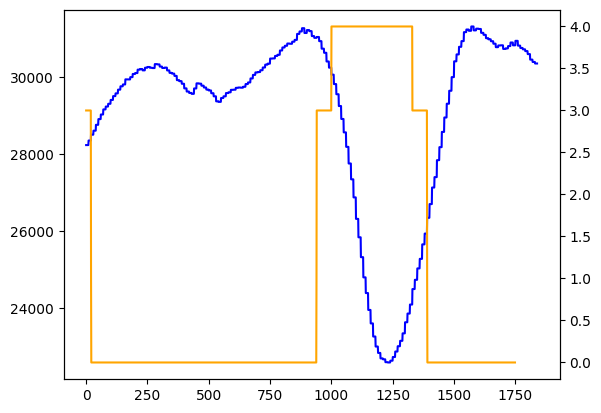

In [65]:
fig, ax1 = plt.subplots()

# Plotten der ersten walk Sequenz
# YOUR CODE HERE
ax1.plot(gonio_data[9300:11139], c='blue')

ax2 = ax1.twinx()

# Plotten der Prädiktion
# YOUR CODE HERE
ax2.plot(prd, c='orange')

Einfacher **Referenzplot**

Euer Plot sieht aufgrund der Initialisierung vermutlich leicht anders aus. Stellt aber für die nächsten Teilaufgaben sicher, dass wir beim Korrigieren den Plot sehen, den ihr in eurer Lösung beschreibt.

<img src="hmm1_ref.png" style="width: 50%">

**4.** In welchem Zustand ist das HMM (Referenzplot) nach 1000 ms?

**5.** Hat das HMM (Referenzplot) eine Topologie gelernt? Wenn nein, warum? Wenn ja, nennt drei Zustandsübergänge.



4.\
Das HMM ist nach 1000ms in einem Zustandsübergang.

5.\
Das HMM weiß nicht, dass es sich um eine (lineare) Topologie handelt. Deswegen ist der Plot auch nicht sehr sinnvoll.

Typischerweise modellieren wir Sequenzen in einer linearen Topologie (vgl. VL 11, Teil 2, Folie 19). Im Folgenden wollen wir deshalb ein Modell mit linearer Topologie trainieren.

In `hmmlearn` könnt ihr ein Modell mit linearer Topologie mithilfe der Attribute `startprob_` und `transmat_` erstellen:
- `startprob` ist die Verteilung der Anfangswahrscheinlichkeit pro Zustand,
- `transmat_` gibt die Übergangswahrscheinlichkeiten in einer Matrix an (also `mtr[0,0]` ist die Wahrscheinlickeit von Zustand 0 zum Zustand 0 zu gehen).

**6.** Überschreibt in einem ersten Schritt die drei Variablen `hmm_params`, `start_prob` und `transmat`. Die Wahrscheinlichkeit in einem Zustand zu bleiben soll 0,7 und in den nächsten überzugehen 0,3 betragen (außer im letzen Zustand). Nutzt wieder 5 Zustände, diesmal mit 5 Gaussverteilungen pro Zustand.

_Notiz_: `**dictionary`, ist ein Pythonkürzel, welches alle `keys` des `dictionary`s als Parameternamen 
und die korrespondierenden `values` als Werte in den Funktionsaufruf einsetzt. 

In [66]:
hmm_params = {'n_components': 0, 'n_mix': 0}
start_prob = np.array([])
transmat = np.array([])

# YOUR CODE HERE
hmm_params['n_components'] = 5
hmm_params['n_mix'] = 5

start_prob = np.array([1.0, 0.0, 0.0, 0.0, 0.0])

transmat = np.array ([[0.7, 0.3, 0.0, 0.0, 0.0],
                      [0.0, 0.7, 0.3, 0.0, 0.0],
                      [0.0, 0.0, 0.7, 0.3, 0.0],
                      [0.0, 0.0, 0.0, 0.7, 0.3],
                      [0.0, 0.0, 0.0, 0.0, 1.0]])

model2 = hmm.GMMHMM(init_params="mwc", params="stmwc", **hmm_params) 
model2.startprob_ = start_prob
model2.transmat_ = transmat

In [ ]:
# Euer Ergebnis wird automatisch getestet.

**7.** Trainiert euer neues Modell `model2` wie oben auf dem Goniometer-Kanal `Gonio2` aus `walk_data_train` und berechnet erneut die wahrscheinlichste Zustandsfolge der ersten walk Sequenz aus `walk_data`. Plottet anschließend euer Ergebnis.

Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


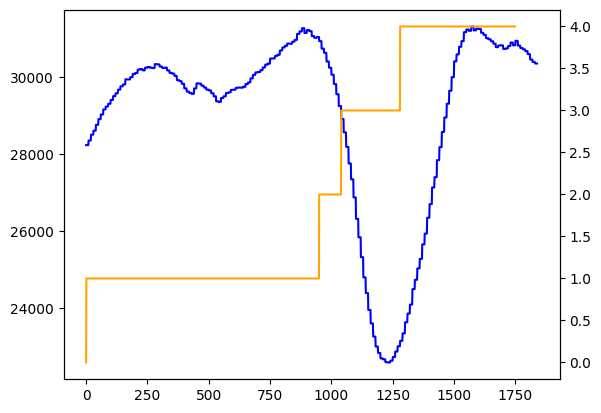

In [70]:
prd2 = []

# YOUR CODE HERE
model2.fit(walk_data_train[:,13].reshape(-1, 1), walk_durations)
prd2 = model2.predict(gonio_data[9390:11139])

fig, ax1 = plt.subplots()

# Plotten der ersten walk Sequenz
ax1.plot(gonio_data[9300:11139], c='blue')

ax2 = ax1.twinx()

# Plotten der Prädiktion
ax2.plot(prd2, c='orange')

Einfacher **Referenzplot**

Euer Plot sieht aufgrund der Initialisierung vermutlich leicht anders aus. Stellt aber für die nächsten Teilaufgaben sicher, dass wir beim Korrigieren den Plot sehen, den ihr in eurer Lösung beschreibt.

<img src="hmm2_ref.png" style="width: 50%">

Vergleicht die wahrscheinlichste Zustandsfolge des HMMs (Referenzplot) mit den Phasen des Ganges (z.B. Mid-Stance, Terminal-Swing etc). Siehe Grafik oben aus Whittle 2007. 

**8.** Hat das HMM die richtige Phaseneinteilung gelernt?

**9.** Woran könnte das liegen?

**10.** Was könntet ihr tun, um die Phasen besser zu erkennen? Nennt und erklärt zwei Möglichkeiten.


8.\
Die Zeitpunkte der Zustandsübergänge kann das HMM anscheinend erkennen, aber das Prediction-Signal ist immer noch sinnlos.

9.\
Höchstwahrscheinlich liegt das daran, dass das HMM die Emissionswahrscheinlichkeiten der jeweiligen Zustände nicht kennt.

10.\
Emissionswahrscheinlichkeiten anzugeben, wäre der erste Schritt. Dann wüsste das HMM, wie wahrscheinlich es ist, sich in einem bestimmten Zustand zu befinden. Außerdem könnte man die Phasen besser erkennen, wenn man mehr Sensoren anlegt. Das verbessert die Differenzierbarkeit von Zuständen, in denen das Gonio-Signal gleich ist.